In [18]:
#Loagind all libraries we will use
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import math
pd.set_option('display.max_rows', 3000)
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import math
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.preprocessing import RobustScaler

In [19]:
#Getting the actual working directory
import os
os.getcwd()

'/Users/neutonfonseca/Neuton/NYC Data Science Bootcamp/Machine Learning/PROJECT'

In [20]:
#Setting the working directory
os.chdir('/Users/neutonfonseca/Neuton/NYC Data Science Bootcamp/Machine Learning/PROJECT/')

In [21]:
#Loading the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [22]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index)

In [23]:
#Save the 'Id' column to use to predict the results
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [24]:
#We use the numpy fuction log1p which applies log(1+x) to all elements of the column SalePrice
train["SalePrice"] = np.log1p(train["SalePrice"])

In [25]:
#Joining training and test data so we can perform feature engineering on both
ntrain = train.shape[0]
ntest = test.shape[0] #use this for splitting up all_data later
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

(2917, 79)

In [26]:
#Implementing feature egineering
all_data = all_data.drop(labels = 'PoolQC', axis = 1)
all_data = all_data.drop(labels = 'MiscFeature', axis = 1)
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data["LotFrontage"].fillna(0)
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt','GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [27]:
#Selecting columns to apply LabelEncoder
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC',
        'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence',
        'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 
        'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
#Process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [28]:
#Getting dummies for categorical features
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 214)


In [29]:
#Splitting the data into train and test
train = all_data[:ntrain]
test = all_data[ntrain:]

In [30]:
#Defining a function to calcule the RMSE
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
#Bayesian Optimization
#Parameter tuning using Bayesian Optimization
from bayes_opt import BayesianOptimization
from sklearn.cross_validation import cross_val_score
from sklearn import ensemble
def gbcv(n_estimators, learning_rate, max_depth, min_samples_leaf, min_samples_split, subsample):
    return cross_val_score(
        ensemble.GradientBoostingRegressor(
        n_estimators = int(n_estimators),
        learning_rate = float(learning_rate),
        max_depth = int(max_depth),
        min_samples_leaf = int(min_samples_leaf),
        min_samples_split = int(min_samples_split),
        subsample = float(subsample),
        random_state = 42),
        train, y_train, 'neg_mean_squared_error', cv = 5
    ).mean()

gbBo = BayesianOptimization(gbcv,
                            {'n_estimators' : (1000, 10000),
                             'learning_rate' : (.01, .1),
                             'max_depth' : (1,10),
                             'min_samples_leaf' : (1,20),
                             'min_samples_split' : (5,25),
                             'subsample' : (1),
                            }
                            )

gbBo.maximize(n_iter = 20)

In [ ]:
gbBo.res['max']

In [14]:
#Running Gradient Boosting with the best parameters
GBoost1 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.0465,
                                   max_depth=2, max_features='sqrt',
                                   min_samples_leaf=3, min_samples_split=18, 
                                   loss='huber', random_state = 5)
GBoost1.fit(train.values, y_train)
score = rmsle_cv(GBoost1)
print("Gradient Boosting1 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting1 score: 0.1093 (0.0056)



In [31]:
#Predicting the SalePrice and creating the csv file for submission using GradientBoosting
GB_pred_train = np.expm1(GBoost1.predict(train.values))
GB_pred_test = np.expm1(GBoost1.predict(test.values))
GBSubmission = pd.DataFrame({ 'Id': test_ID,
                            'SalePrice': GB_pred_test})
GBSubmission.to_csv("GBSubmission_test.csv", index=False)

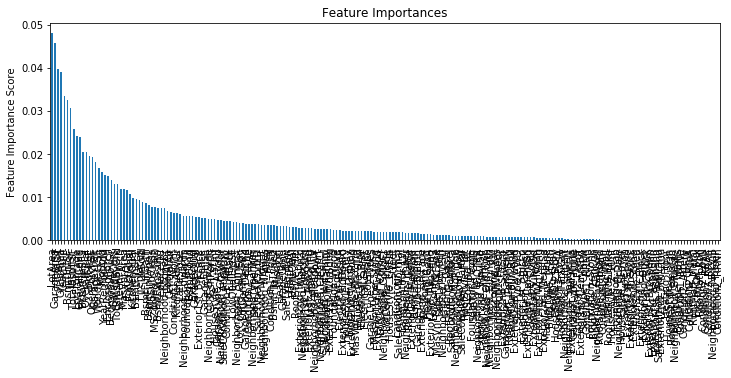

In [32]:
#Checking the feature importance for Gradient Boosting
gb_feature_importance = GBoost1.feature_importances_
gb_feature_importance = 100.0 * (gb_feature_importance / gb_feature_importance.max())
#pyplot.bar(range(len(GBoost1.feature_importances_)), GBoost1.feature_importances_)
#pyplot.show()
feat_imp = pd.Series(GBoost1.feature_importances_, train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')